In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import pandas as pd
import Scripts.airfoil as af
import Scripts.fishUtilities as fu
import Scripts.fishFits as ff
import Scripts.surfaceAreaEstimators as sea
import Scripts.volumeEstimators as ve
import Scripts.cotEstimators as cot

from pathlib import Path

In [2]:
imagePath = r'./Pictures'
figurePath = r'./Figures/'
dataBase = r'./PowerAndThrustData.xlsx'
specimens = ['harvard', 'mitc', 'nyuiDevice', 'NRL']

In [3]:
imagePathSide = []
imagePathSideFull = []
imagePathTop = []
imagePathTopFull = []

for specimen in specimens:
    imagePathSide.append(fu.get_image_files(imagePath, specimen + 'SideNF.png'))
    imagePathSideFull.append(fu.get_image_files(imagePath, specimen + 'Side.png'))

    imagePathTopGet = fu.get_image_files(imagePath, specimen + 'TopNF.png')
    imagePathTopFullGet = fu.get_image_files(imagePath, specimen + 'Top.png')

    if(len(imagePathTopFullGet) == 0):
        imagePathTopFull.append(imagePathTopGet)
        imagePathTop.append(imagePathTopGet)
    else:
        imagePathTopFull.append(imagePathTopFullGet)
        imagePathTop.append(imagePathTopGet)

In [4]:
# Split work depending on input images
def process_top(imageList):
    # make a copy of the image
    topImage = imageList[0].copy()
    if(len(imageList) < 2):
        topImageFull = imageList[0].copy()
    else:
        topImageFull = imageList[1].copy()
    # get contours
    cntsTop, hullTop = fu.get_contours(topImage)
    cntsTopFull, hullTopFull = fu.get_contours(topImageFull)
    
    # Find the area ratio of fins and no fins
    areaTopFull = cv2.contourArea(cntsTopFull)
    areaTopNF = cv2.contourArea(cntsTop)
    areaRatioTop = (1-np.abs(areaTopNF/areaTopFull))

    # split the hull into top and bottom
    (cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(topImage.shape, cntsTop)
    (cxTopFull, cyTopFull), topHullTopFull, bottomHullTopFull = fu.split_by_centroid_top(topImageFull.shape, cntsTopFull)

    # scale contour data
    areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
    areaTopFull, tHullTopFull, bHullTopFull = fu.scale_data_top(topHullTopFull, bottomHullTopFull)
    
    # get min and max points
    maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
    
    # fit data
    topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
    nacaArea, m, thickness, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, np.mean([minPointsTop[0],maxPointsTop[0]]), np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
    
    return (areaRatioTop, [cntsTop, cntsTopFull], [maxPointsTop[1], minPointsTop[1]],
            [topFitTop, bottomFitTop], [m, thickness, d0], [tHullTop, bHullTop])

In [5]:
def process_side(imageList):
    # make a copy of the image
    sideImage = imageList[0].copy()
    sideImageFull = imageList[1].copy()

    # get contours
    cntsSide, hullSide = fu.get_contours(sideImage)
    cntsSideFull, hullSideFull = fu.get_contours(sideImageFull)
    
    # Find the area ratio of fins and no fins
    areaSideFull = cv2.contourArea(cntsSideFull)
    areaSideNF = cv2.contourArea(cntsSide)
    areaRatioSide = (1-np.abs(areaSideNF/areaSideFull))
    
    (cxSide, cySide), areaSideNF, topHullSide, bottomHullSide = fu.split_by_centroid_side(sideImage.shape, cntsSide)
    (cxSideFull, cySideFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(sideImageFull.shape, cntsSideFull)

    # scale contour data
    scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
    scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
    
    # get min and max points
    maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
    
    #fit data
    topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
    
    return (areaRatioSide, [cntsSide, cntsSideFull], [maxPointsSide[1], minPointsSide[1]], [topFitSide, bottomFitSide], [tHullSide, bHullSide])

In [6]:
# Side Data
sideArea = np.zeros(len(specimens))
maxPointsSide = np.zeros(len(specimens))
minPointsSide = np.zeros(len(specimens))
topFitSide = np.zeros((len(specimens), 7))
bottomFitSide = np.zeros((len(specimens), 7))
# Top Data
topArea = np.zeros(len(specimens))
maxPointsTop = np.zeros(len(specimens))
minPointsTop = np.zeros(len(specimens))
topFitTop = np.zeros((len(specimens), 7))
bottomFitTop = np.zeros((len(specimens), 7))
nacaCoeffs = np.zeros((len(specimens), 3))

for idx, specimen in enumerate(specimens):
    # import images
    imageSide = cv2.imread(imagePathSide[idx][0].as_posix())
    imageSideFull = cv2.imread(imagePathSideFull[idx][0].as_posix())

    # import images
    imageTop = cv2.imread(imagePathTop[idx][0].as_posix())
    imageTopFull = cv2.imread(imagePathTopFull[idx][0].as_posix())

    sideArea[idx], sideContours, sidePoints, sideFits, sideHull = process_side([imageSide, imageSideFull])
    maxPointsSide[idx] = sidePoints[0]
    minPointsSide[idx] = sidePoints[1]
    topFitSide[idx,:] = sideFits[0]
    bottomFitSide[idx,:] = sideFits[1]

    topArea[idx], topContours, topPoints, topPolyFits, nacaCoeffs[idx,:], topHull = process_top([imageTop, imageTopFull])
    maxPointsTop[idx] = topPoints[0]
    minPointsTop[idx] = topPoints[1]
    topFitTop[idx,:] = topPolyFits[0]
    bottomFitTop[idx,:] = topPolyFits[1]

In [7]:
lengths = [0.548, 0.1265, 0.0452, 0.43815]
surfaceArea = [0.1365688, 0.0128, 0.0032, 0.224]
mass = [2.79, 0.068, 0.009, 2.9]
density = 1025
sArea = np.zeros((len(specimens), 5))
calc_mass = np.zeros((len(specimens), 5))
volume = np.zeros((len(specimens), 5))

for idx, specimen in enumerate(specimens):
    # NACA Fit
    sArea[idx,0], _  = sea.determine_surface_area(1, 2, 0, lengths[idx], topFitSide[idx], bottomFitSide[idx], nacaCoeffs[idx], nacaCoeffs[idx])
    volume[idx,0], _, _ = ve.determine_volume(1, 2, 0, lengths[idx], topFitSide[idx], bottomFitSide[idx], nacaCoeffs[idx], nacaCoeffs[idx])
    calc_mass[idx,0] = volume[idx,0] * density
    # PolyFit
    sArea[idx,1], _ = sea.determine_surface_area(0, 2, 0, lengths[idx], topFitSide[idx], bottomFitSide[idx], topFitTop[idx], bottomFitTop[idx])
    volume[idx,1], _, _ = ve.determine_volume(0, 2, 0, lengths[idx], topFitSide[idx], bottomFitSide[idx], topFitTop[idx], bottomFitTop[idx])
    calc_mass[idx,1] = volume[idx,1] * density
    # tri-axial ellipsoid
    _, sArea[idx, 2], _ = sea.equivalentSpheroid(lengths[idx], mass[idx], density)
    volume[idx,2] = ve.equivalentSpheroid(lengths[idx], mass[idx], density)
    calc_mass[idx,2] = volume[idx,2] * density
    # Ellipsoid Approximation
    sArea[idx,3] = sea.ellipsoidApproximation(lengths[idx], np.abs(maxPointsSide[idx]) + np.abs(minPointsSide[idx]), np.abs(maxPointsTop[idx]) + np.abs(minPointsTop[idx]))
    volume[idx,3] = ve.ellipsoidApproximation(lengths[idx], np.abs(maxPointsSide[idx]) + np.abs(minPointsSide[idx]), np.abs(maxPointsTop[idx]) + np.abs(minPointsTop[idx]))
    calc_mass[idx,3] = volume[idx,3] * density
    # Partition Disc
    sArea[idx,4] = sea.partitionDisc(lengths[idx], topFitSide[idx], bottomFitSide[idx], topFitTop[idx], bottomFitTop[idx])
    volume[idx,4] = ve.partitionDisc(lengths[idx], topFitSide[idx], bottomFitSide[idx], topFitTop[idx], bottomFitTop[idx])
    calc_mass[idx,4] = volume[idx,4] * density

/home/mco143/Documents/gitRepos/fish_contours/Scripts/surfaceAreaEstimators.py:282: RuntimeWarning: invalid value encountered in sqrt
  eccentricity = np.sqrt(1.0-(b**2/a**2))


In [8]:
sAreaError = np.zeros((len(specimens), 5))
massError = np.zeros((len(specimens), 5))

for idx in range(5):
    sAreaError[:, idx] = np.divide(np.abs(sArea[:,idx]-surfaceArea), surfaceArea) * 100
    massError[:, idx] = np.divide(np.abs(calc_mass[:,idx]-mass), mass) * 100

<ipython-input-9-6250079a842e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Harvard Beihang \n' +  'Mackerel', 'MIT Carangiform', 'New York University \n' + 'iDevice', 'Naval Research \n' + 'Laboratories 4-Fin'], rotation=45)


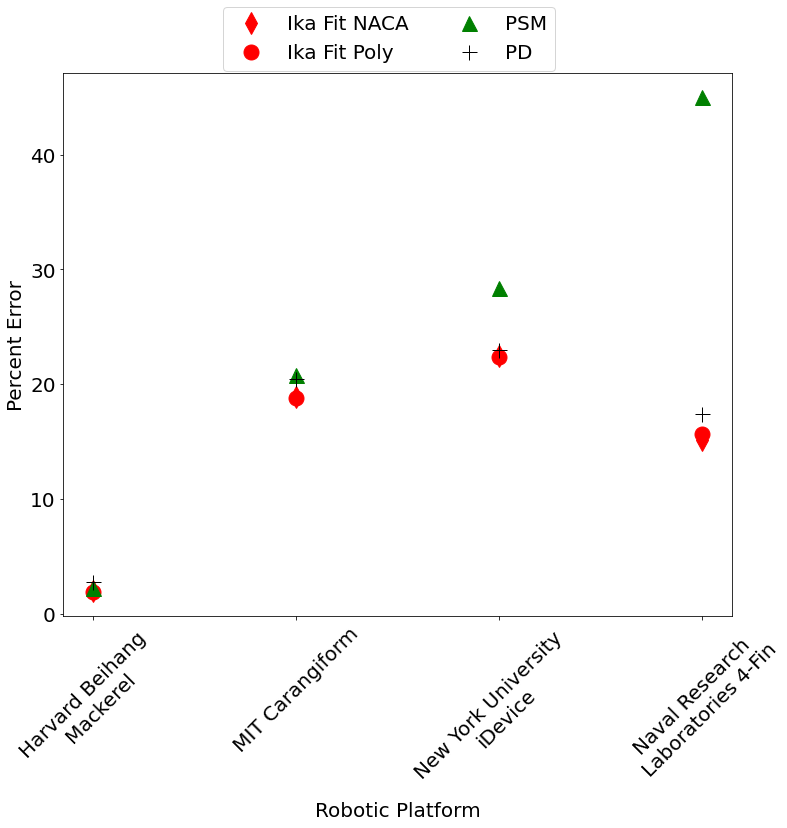

In [9]:
plt.rcParams.update({'font.size': 20, 'lines.markersize':15})
#plt.style.use('grayscale')
fig1, ax1 = plt.subplots(figsize=((12, 10)))
ax1.plot(specimens, sAreaError[:,0], 'rd', label='Ika Fit NACA')
ax1.plot(specimens, sAreaError[:,1], 'ro', label='Ika Fit Poly')
ax1.plot(specimens, sAreaError[:,2], 'g^', label='PSM')
#ax1.plot(specimens, sAreaError[:,3], 'gx', label='PSR')
ax1.plot(specimens, sAreaError[:,4], 'k+', label='PD')
ax1.set_xticklabels(['Harvard Beihang \n' +  'Mackerel', 'MIT Carangiform', 'New York University \n' + 'iDevice', 'Naval Research \n' + 'Laboratories 4-Fin'], rotation=45)
ax1.set_xlabel("Robotic Platform")
ax1.set_ylabel("Percent Error")
ax1.legend(loc='best', ncol=2, bbox_to_anchor=(0.75, 1.14))
fig1.savefig(Path(figurePath).joinpath('Robot_comparison.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

<ipython-input-10-7c89b95aeeaa>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Harvard Beihang \n' +  'Mackerel', 'MIT Carangiform', 'New York University \n' + 'iDevice', 'Naval Research \n' + 'Laboratories 4-Fin'], rotation=45)


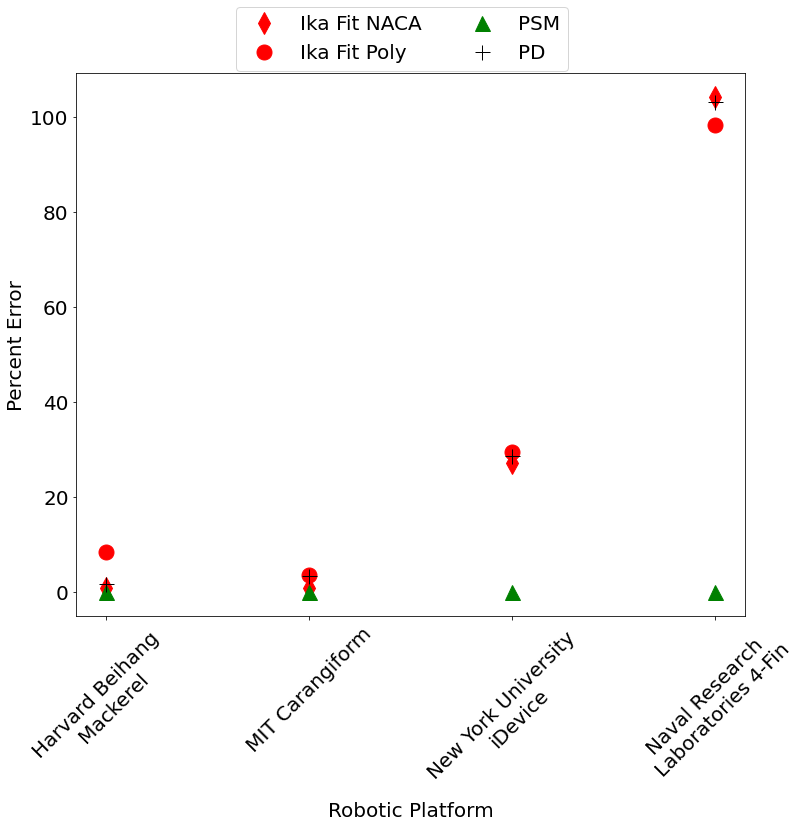

In [10]:
#plt.style.use('grayscale')
fig2, ax2 = plt.subplots(figsize=((12, 10)))
ax2.plot(specimens, massError[:,0], 'rd', label='Ika Fit NACA')
ax2.plot(specimens, massError[:,1], 'ro', label='Ika Fit Poly')
ax2.plot(specimens, massError[:,2], 'g^', label='PSM')
#ax1.plot(specimens, sAreaError[:,3], 'gx', label='PSR')
ax2.plot(specimens, massError[:,4], 'k+', label='PD')
ax2.set_xticklabels(['Harvard Beihang \n' +  'Mackerel', 'MIT Carangiform', 'New York University \n' + 'iDevice', 'Naval Research \n' + 'Laboratories 4-Fin'], rotation=45)
ax2.set_xlabel("Robotic Platform")
ax2.set_ylabel("Percent Error")
ax2.legend(loc='best', ncol=2, bbox_to_anchor=(0.75, 1.14))
fig2.savefig(Path(figurePath).joinpath('Robot_mass.pdf'), facecolor='w', bbox_inches='tight', dpi=300)

In [11]:
calc_mass

array([[2.80878923e+00, 3.02207098e+00, 2.79000000e+00, 1.45642333e+01,
        2.83242453e+00],
       [6.84413400e-02, 7.03700884e-02, 6.80000000e-02, 8.69412907e+00,
        7.02310144e-02],
       [1.14433100e-02, 1.16488508e-02, 9.00000000e-03, 6.01925993e+00,
        1.15718169e-02],
       [5.91772430e+00, 5.75165345e+00, 2.90000000e+00, 4.92725481e+01,
        5.89050934e+00]])